# This notebook loads, cleans, and prepares the data for analysis

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from datetime import datetime

### Data Structure

In [2]:
# load in the data and view it
df = pd.read_csv('../data/NYC_Restaurant_Inspections.csv')
df.head()

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,...,INSPECTION TYPE,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA,Location Point1
0,50141818,WHOOPIE COMPANY,Manhattan,42,BROADWAY,10004.0,2015460996,NaN,01/01/1900,NaN,...,NaN,40.706263,-74.012909,101.0,1.0,900.0,1000812.0,1.000220e+09,MN25,NaN
1,50143760,88 CANTEEN,Queens,5846,MAIN ST,11355.0,7183741992,Chinese,12/30/2024,Violations were cited in the following area(s).,...,Cycle Inspection / Initial Inspection,40.744133,-73.825739,407.0,20.0,80301.0,4139597.0,4.063780e+09,QN62,NaN
2,50106453,ARANA EN EL JARDIN,Manhattan,511,EAST 5 STREET,10009.0,2127772017,NaN,01/01/1900,NaN,...,NaN,40.724647,-73.983884,103.0,2.0,3200.0,1005078.0,1.004010e+09,MN22,NaN
3,50161272,GEORGIE'S,Manhattan,182,BROOME STREET,10002.0,6317404946,NaN,01/01/1900,NaN,...,NaN,40.716965,-73.986407,103.0,1.0,1402.0,1089891.0,1.003468e+09,MN28,NaN
4,50160742,UNIQLO USA LLC,Manhattan,666,5TH AVE,10103.0,9178370057,NaN,01/01/1900,NaN,...,NaN,40.760542,-73.976421,105.0,4.0,10400.0,1034520.0,1.012688e+09,MN17,NaN


First, for personal preference's sake, I will make all the column names lowercase.

In [3]:
df.columns = [name.lower() for name in list(df.columns)]
df.columns

Index(['camis', 'dba', 'boro', 'building', 'street', 'zipcode', 'phone',
       'cuisine description', 'inspection date', 'action', 'violation code',
       'violation description', 'critical flag', 'score', 'grade',
       'grade date', 'record date', 'inspection type', 'latitude', 'longitude',
       'community board', 'council district', 'census tract', 'bin', 'bbl',
       'nta', 'location point1'],
      dtype='object')

For readability, I will rename a few of the columns, based on both the documentation and a bit of research (for BBL, BIN, and NTA).

In [4]:
df.rename(columns = {
    'camis': 'restaurant_id',
    'dba': 'restaurant_name',
    'boro': 'borough',
    'building': 'building_number',
    'street': 'street_name',
    'phone': 'phone_number',
    'cuisine description': 'cuisine_description',
    'inspection date': 'inspection_date',
    'action': 'action_taken',
    'violation code': 'violation_code',
    'violation description': 'violation_description',
    'critical flag': 'critical_flag',
    'grade date': 'grade_date',
    'record date': 'record_date',
    'inspection type': 'inspection_type',
    'community board': 'community_board',
    'council district': 'council_district',
    'census tract': 'census_tract',
    'bin': 'building_id',
    'bbl': 'borough_block_lot',
    'nta': 'neighborhood_tabulation_area',
    'location point1': 'location_point_1'},
    inplace=True)
df.columns

Index(['restaurant_id', 'restaurant_name', 'borough', 'building_number',
       'street_name', 'zipcode', 'phone_number', 'cuisine_description',
       'inspection_date', 'action_taken', 'violation_code',
       'violation_description', 'critical_flag', 'score', 'grade',
       'grade_date', 'record_date', 'inspection_type', 'latitude', 'longitude',
       'community_board', 'council_district', 'census_tract', 'building_id',
       'borough_block_lot', 'neighborhood_tabulation_area',
       'location_point_1'],
      dtype='object')

Now, let's observe the general characteristics of the dataframe itself, such as its shape and data types.

In [5]:
df.shape

(289021, 27)

There are just over 289,000 observations in this dataframe, and 27 features.

In [6]:
df.dtypes

restaurant_id                     int64
restaurant_name                  object
borough                          object
building_number                  object
street_name                      object
zipcode                         float64
phone_number                     object
cuisine_description              object
inspection_date                  object
action_taken                     object
violation_code                   object
violation_description            object
critical_flag                    object
score                           float64
grade                            object
grade_date                       object
record_date                      object
inspection_type                  object
latitude                        float64
longitude                       float64
community_board                 float64
council_district                float64
census_tract                    float64
building_id                     float64
borough_block_lot               float64


We see that many of the data types appear correct, but many will require further investigation and may potentially need to be cast to others.  We will address that a bit later.  For now, we will identify any features that will be irrelevant for our analysis.

### Removing Unnecessary Features

While the restaurant name and ID will not ultimately be fed into our model, we will need both for feature engineering purposes, so we will hold on to them for now.  The building number, street name, and phone number can all be dropped for now.  The first two can be dropped since we have better geographic information to feed into our model and to use to summarize results (such as the borough, zip code, and coordinates).  The latter simply is irrelevant for our analysis.  The grade date and record date can similarly be dropped, as the date we are interested in is the date of inspection (since that is the date we will be predicting a grade for).  The community board, council district, census tract, and building ID can also be dropped, since these are included for other purposes.  Let's go ahead and drop these features for now.

In [7]:
df = df.drop([
    'building_number',
    'street_name',
    'phone_number',
    'grade_date',
    'record_date',
    'community_board',
    'council_district',
    'census_tract',
    'building_id'
],
axis=1)

In [8]:
# Check the shape after dropping columns
df.shape

(289021, 18)

We now have 18 features to work with, but keep in mind we will be adding and removing plenty more due to the nature of our feature engineering task.

### Handling Missing Data

Let's now get an idea of the fill rates for our data set.  Let's look at the proportion of nulls by column

In [9]:
# look at the columns with the most null values
nulls = df.isnull().sum()/df.shape[0]
nulls.sort_values(ascending=False).head(10)

location_point_1                1.000000
grade                           0.512029
score                           0.055439
violation_code                  0.020504
violation_description           0.020504
neighborhood_tabulation_area    0.013034
cuisine_description             0.013013
action_taken                    0.013013
inspection_type                 0.013013
zipcode                         0.010089
dtype: float64

The location_point_1 feature is missing all entries.  We can remove it, as it is useless for our purposes.

In [10]:
df = df.drop('location_point_1', axis=1)

The grade is our response variable.  The fact that it is missing over half its values is concerning, but the good news is that we know the grade is a direct result of the score.  Furthermore, we know we will want to binarize the grade, which means that any score between 0 and 13 (inclusive) will result in an A, while scores above 13 will result in a non-A.  Let's observe the unique scores in our dataframe, then, and particularly look at where scores are missing, to see if we can remove the grade column and engineer its binarized replacement.

In [11]:
# Verify that score values are either numbers or nulls
df['score'].unique()

array([ nan,  12.,  28.,  50.,  46.,   0.,  15.,  27.,  10.,   9.,  29.,
        31.,  25.,  16.,  65.,  11.,   7.,  43.,  13.,  21.,  19.,  37.,
        87.,  18.,  34.,  54.,  33.,  30.,  68.,  22.,  24.,  26.,  79.,
        49.,  36.,  38.,  23.,  82.,   8.,  55.,  40.,  45.,  78.,  51.,
        35.,  53.,   2.,  20.,  41.,  39.,  74.,  70., 127.,  47.,   4.,
        44.,  48.,  59.,  14.,  17.,  32.,  42.,  58.,   5.,  61.,  56.,
        76.,  52.,  62.,   6.,  75.,  92.,  63.,  80.,  67.,  60.,   3.,
        57.,  71.,  95.,  81.,  72.,  66.,  94.,  73.,  89.,  69., 116.,
       103.,  85., 100.,  91.,  86., 102.,  88., 168., 175.,  84.,  83.,
       129.,  97., 118., 134., 110., 113.,  90., 114., 131., 112.,  96.,
        64.,  77.,  93.,  99., 142.,  98., 101., 104., 115., 107., 111.,
       108., 135., 120., 106., 144., 128., 125., 136., 139., 123., 109.,
       122., 153., 124., 121., 105., 137., 154., 132., 141., 138., 140.])

We know from the documentation that records with an inspection date of 01/01/1900 are new restaurants that have not yet received an inspection.  These would obviously not have a score.  Let's see how many of the rows with empty scores are for new restauarants.

In [12]:
# See how many of the rows with null scores are for new restaurants
df[df['score'].isnull()]['inspection_date'].value_counts(normalize=True)[:5]

inspection_date
01/01/1900    0.234725
01/14/2025    0.002559
03/12/2025    0.002559
03/11/2025    0.002496
04/29/2025    0.002496
Name: proportion, dtype: float64

In [13]:
# Verify that no new restaurants have an inspection score
df[df['inspection_date']=='01/01/1900']['score'].unique()

array([nan])

About a quarter of these rows with null scores are for new restaurants.  As we show above, no new restaurants have a score.  Ultimately, these new restaurants will not be able to be used in our out-of-time data or for model building at all, since they do not and cannot yet have a label.  Although our model could in theory predict scores for new restaurants, the "new restaurants" our model will be trained on will have to be from previous years, not from this year.  Thus, we will drop all the new restaurants in our dataframe as of this timeframe.

In [14]:
# Drop the new restaurants from our dataframe
df = df[df['inspection_date']!='01/01/1900']

In [15]:
# Re-examine the nulls
nulls = df.isnull().sum()/df.shape[0]
nulls.sort_values(ascending=False).head(10)

grade                           0.505595
score                           0.042985
neighborhood_tabulation_area    0.012767
zipcode                         0.009977
violation_code                  0.007590
violation_description           0.007590
borough_block_lot               0.002790
latitude                        0.001297
longitude                       0.001297
action_taken                    0.000000
dtype: float64

Theoretically, the violation code and violation description should be missing when there are no violations found.  There is a flag for this in the action taken column.  Let's examine these rows and see if some of them may mistakenly have violation descriptions.

In [16]:
# Grab rows with no violations found and print the number of them
no_vios = df[df['action_taken'].isin(['No violations were recorded at the time of this inspection.'])]
print(f'{len(no_vios)} inspections are recorded as not having violations')
# See if any have values in violation_code or violation_description
potential_errors = no_vios[(~no_vios['violation_code'].isnull()) | (~no_vios['violation_description'].isnull())]
print(f'{len(potential_errors)} entries may have data entry errors')
potential_errors.head(5)


2168 inspections are recorded as not having violations
189 entries may have data entry errors


,restaurant_id,restaurant_name,borough,zipcode,cuisine_description,inspection_date,action_taken,violation_code,violation_description,critical_flag,score,grade,inspection_type,latitude,longitude,borough_block_lot,neighborhood_tabulation_area
2405,50136408,SUSHI W,Manhattan,10029.0,Japanese,08/01/2023,No violations were recorded at the time of thi...,15-37,Workplace SFAA policy not prominently posted i...,Not Applicable,NaN,NaN,Smoke-Free Air Act / Initial Inspection,40.786848,-73.950198,1.016250e+09,MN33
5869,50146369,GLAZE UNION SQUARE,Manhattan,10003.0,Japanese,08/07/2024,No violations were recorded at the time of thi...,20-04,“Choking first aid” poster not posted. “Alcoho...,Not Critical,NaN,NaN,Administrative Miscellaneous / Initial Inspection,40.734277,-73.992495,1.005708e+09,MN23
7068,50105792,LIT. BOOKBAR,Bronx,10454.0,American,08/24/2022,No violations were recorded at the time of thi...,18-11,Food Protection Certificate not available for ...,Not Critical,NaN,NaN,Administrative Miscellaneous / Initial Inspection,40.807248,-73.927198,2.023090e+09,BX39
11353,50167936,MICCO CAFE,Queens,11361.0,Coffee/Tea,04/22/2025,No violations were recorded at the time of thi...,20-04,“Choking first aid” poster not posted. “Alcoho...,Not Critical,NaN,NaN,Administrative Miscellaneous / Initial Inspection,40.759348,-73.768810,4.073320e+09,QN46
12005,50131492,KAIFF,Brooklyn,11207.0,American,03/06/2023,No violations were recorded at the time of thi...,20-01,Food allergy information poster not conspicuou...,Not Critical,NaN,NaN,Administrative Miscellaneous / Initial Inspection,40.683649,-73.911797,3.015078e+09,BK79


We see 189 of the 2168 inspections recorded as not having violations actually do have violations recorded.  This may well be a data entry error, and it is difficult to tell how to resolve it, since we don't know if the error was in recording the violation or in the action taken column.  Thus, we will simply remove these rows from our dataframe for now, especially since they are not terribly numerous relative to the rest of the data.

In [17]:
# Remove the rows with potential data entry errors as indicated above
df = df[~((df['action_taken']=='No violations were recorded at the time of this inspection.') & (~df['violation_code'].isnull()))]

As for the rest of the nulls in the violation description and violation code column, we can keep them if the action taken either indicates no violations or a restaurant reopening as a result of the inspection.  However, we will change them to "Not Applicable" to distinguish them from nulls with other action taken entries so they do not get removed when we remove nulls.  

In [18]:
# Check how many entries with null violation code or description are in each categoroy of action taken
df[(df['violation_code'].isnull()) | (df['violation_description'].isnull())]['action_taken'].value_counts()

action_taken
No violations were recorded at the time of this inspection.                                                                           1979
Establishment re-opened by DOHMH.                                                                                                      177
Violations were cited in the following area(s).                                                                                          6
Establishment Closed by DOHMH. Violations were cited in the following area(s) and those requiring immediate action were addressed.       2
Establishment re-closed by DOHMH.                                                                                                        1
Name: count, dtype: int64

In [19]:
# Replace the specified violation code and description entries with 'Not Applicable' when there is no violation or the restaurant reopened
df.loc[((df['violation_code'].isnull()) & (df['violation_description'].isnull()) & (df['action_taken'].isin(['No violations were recorded at the time of this inspection.','Establishment re-opened by DOHMH.']))), 'violation_code'] = 'Not Applicable'
df.loc[((df['violation_description'].isnull()) & (df['action_taken'].isin(['No violations were recorded at the time of this inspection.','Establishment re-opened by DOHMH.']))), 'violation_description'] = 'Not Applicable'

In [20]:
# Check that the imputation was done correctly
df[(df['violation_code'].isnull()) | (df['violation_description'].isnull())]['action_taken'].value_counts()

action_taken
Violations were cited in the following area(s).                                                                                       6
Establishment Closed by DOHMH. Violations were cited in the following area(s) and those requiring immediate action were addressed.    2
Establishment re-closed by DOHMH.                                                                                                     1
Name: count, dtype: int64

The score for these rows in which no violations were found should also be 0 if it is null.  We can impute that now.

In [21]:
# Impute a score of 0 to rows where the violation code is Not Applicable, the action taken indicates no violations, and score is null
df.loc[(df['violation_code']=='Not Applicable') & (df['score'].isnull()) & (df['action_taken'].isin(['No violations were recorded at the time of this inspection.'])), 'score'] = 0

In [22]:
# Check that this imputation was done correctly
df.loc[(df['violation_code']=='Not Applicable') & (df['action_taken'].isin(['No violations were recorded at the time of this inspection.']))]['score'].unique()

array([0.])

In [23]:
# Re-examine the nulls
nulls = df.isnull().sum()/df.shape[0]
nulls = nulls[nulls>0]
nulls.sort_values(ascending=False).head(10)

grade                           0.505299
score                           0.039790
neighborhood_tabulation_area    0.012762
zipcode                         0.009969
borough_block_lot               0.002792
latitude                        0.001298
longitude                       0.001298
violation_code                  0.000032
violation_description           0.000032
dtype: float64

There are still some missing scores nonetheless.  Let's see if there seems to be a pattern for how they are missing based on a few columns of interest: the violation description, borough, and inspection type.  We will first use a MAR test designed to do pairwise chi-squared tests of independence between the column with missing values (score column) and the columns of interest.  We will define the function below and then run it on our score column and the columns of interest.

In [24]:
# Define a function that checks whether the missingness in a column is significantly associated with one or more categorical features using a chi-square test of independence
def MAR_test(df=pd.DataFrame, missing_col=str, cols_of_interest=list, alpha=0.05):
    print(f'MAR test for {missing_col}:')
    # Initialize a significant association flag
    sig_association_found = False
    # Copy the input df
    df_copy = df.copy()
    # Generate a binary missingness indicator for the column with nulls
    missing_ind_colname = missing_col+'_is_missing'
    df_copy[missing_ind_colname] = df_copy[missing_col].apply(lambda x: 1 if pd.isna(x) else 0)
    # For each col of interest, generate a binary contingency table and perform chi-square test of independence
    for col in cols_of_interest:
        contingency_table = pd.crosstab(df_copy[missing_ind_colname], df_copy[col])
        test_statistic, p_value, dof, _ = stats.chi2_contingency(contingency_table)
        if p_value <= alpha:
            sig_association_found = True
            print(f'Missing values associated with {col} with a p-value of {np.round(p_value, 10)}')
    if sig_association_found==False:
        print('Missing values and all columns of interest are independent')
    print('\n')

In [25]:
MAR_test(df=df, missing_col='score', cols_of_interest=['violation_description', 'borough', 'inspection_type'], alpha=0.01)

MAR test for score:
Missing values associated with violation_description with a p-value of 0.0
Missing values associated with borough with a p-value of 0.0
Missing values associated with inspection_type with a p-value of 0.0




In [26]:
# Check the contingency table between the missing scores and the borough to see if our results might be skewed
df_check = df.copy()
df_check['score_missing'] = df_check['score'].apply(lambda x: 1 if pd.isna(x) else 0)
table = pd.crosstab(df_check['borough'], df_check['score_missing'])
table

score_missing,0,1
borough,,
Bronx,25269,1021
Brooklyn,71064,2556
Manhattan,100315,4714
Queens,67408,2818
Staten Island,9672,234


We see highly significant results in our chi-squared tests, but looking at the contingency table for the boroughs does not reveal anything practically significant.  Our MAR test may be skewed due to the large sample size we have and the relatively small proportion of missing scores.  Let's check for an association using correlation instead.  We will factorize the categorical columns of interest and obtain pairwise correlations between these factorized features and the missing scores.  We will check using both Pearson and Spearman correlation.  If a correlation is greater than 0.2, we will call it out.  Let's define a function to do this below, and then run it on the missing scores.

In [27]:
def check_correlation(df=pd.DataFrame, missing_col=str, cat_cols_of_interest=list, sig_corr_lvl=0.2, methods_to_test=['pearson','spearman']):
    print(f'Correlation check for {missing_col}:')
    # Initialize a signficant correlation flag
    sig_correlation_found = False
    # Copy the input df
    df_copy = df.copy()
    # Generate a binary missingness indicator for the column with nulls
    missing_ind_colname = missing_col+'_is_missing'
    df_copy[missing_ind_colname] = df_copy[missing_col].apply(lambda x: 1 if pd.isna(x) else 0)
    # For each col of interest, factorize the column and find its correlation with the missing_col
    for col in cat_cols_of_interest:
        for method in methods_to_test:
            labs, cats = pd.factorize(df_copy[col])
            new_colname = col+'_factorized'
            df_copy[new_colname] = labs
            # Obtain the pairwise correlation using the input method - default is Pearson
            correlation = df_copy[[missing_ind_colname, new_colname]].corr(method=method).iloc[0,1]
            if correlation >= sig_corr_lvl:
                sig_correlation_found = True
                print(f'Signficant correlation found with {col} using {method} method - correlation = {correlation}')
    if sig_correlation_found==False:
        print('No significant correlations found')
    print('\n')
        

In [28]:
check_correlation(df=df, missing_col='score', cat_cols_of_interest=['violation_description', 'borough', 'inspection_type'])

Correlation check for score:
No significant correlations found




Here, we see no meaningful correlations.  We will thus go ahead and remove the grade column, as well as all the nulls in the score column.

In [29]:
df = df.drop('grade', axis=1)
df = df.dropna(axis=0, subset=['score'])

In [30]:
# Re-examine the nulls
nulls = df.isnull().sum()/df.shape[0]
nulls[nulls>0].sort_values(ascending=False)

neighborhood_tabulation_area    0.012852
zipcode                         0.010036
borough_block_lot               0.002817
latitude                        0.001319
longitude                       0.001319
violation_code                  0.000029
violation_description           0.000029
dtype: float64

For these remaining features, we will first use our correlation check to detect problematic correlations with our columns of interest.  If they do not exist, then we can drop the nulls in these columns as well.

In [31]:
# Grab the remaining columns containing nulls
null_cols = list(nulls[nulls>0].index)
# Perform our correlation check on each
for col in null_cols:
    check_correlation(df=df, missing_col=col, cat_cols_of_interest=['violation_description', 'borough', 'inspection_type'])

Correlation check for zipcode:
No significant correlations found


Correlation check for violation_code:
No significant correlations found


Correlation check for violation_description:
No significant correlations found


Correlation check for latitude:
No significant correlations found


Correlation check for longitude:
No significant correlations found


Correlation check for borough_block_lot:
No significant correlations found


Correlation check for neighborhood_tabulation_area:
No significant correlations found




Since there are no noteworthy correlations, we will drop the nulls in these columns.  They comprise far less than 5% of observations anyways.

In [32]:
df = df.dropna(axis=0, subset=null_cols)

In [33]:
# Ensure there are no more nulls
df.isnull().sum().sum()

0

### Formatting and Data Types

Next, we will make sure the data types are all as we want them to be.

In [34]:
df.dtypes

restaurant_id                     int64
restaurant_name                  object
borough                          object
zipcode                         float64
cuisine_description              object
inspection_date                  object
action_taken                     object
violation_code                   object
violation_description            object
critical_flag                    object
score                           float64
inspection_type                  object
latitude                        float64
longitude                       float64
borough_block_lot               float64
neighborhood_tabulation_area     object
dtype: object

First of all, it looks like all the numeric data types except for latitude and longitutde can be converted to integers, so let's do that now.

In [35]:
# Convert numeric data types to integers except latitude and longitude
df = df.astype({
    'zipcode': 'int64',
    'score': 'int64',
    'borough_block_lot': 'int64'
})
df.dtypes

restaurant_id                     int64
restaurant_name                  object
borough                          object
zipcode                           int64
cuisine_description              object
inspection_date                  object
action_taken                     object
violation_code                   object
violation_description            object
critical_flag                    object
score                             int64
inspection_type                  object
latitude                        float64
longitude                       float64
borough_block_lot                 int64
neighborhood_tabulation_area     object
dtype: object

Now, we will convert the inspection date to a datetime object.

In [36]:
df['inspection_date'] = pd.to_datetime(df['inspection_date'])
df.dtypes

restaurant_id                            int64
restaurant_name                         object
borough                                 object
zipcode                                  int64
cuisine_description                     object
inspection_date                 datetime64[ns]
action_taken                            object
violation_code                          object
violation_description                   object
critical_flag                           object
score                                    int64
inspection_type                         object
latitude                               float64
longitude                              float64
borough_block_lot                        int64
neighborhood_tabulation_area            object
dtype: object

All our data types now look as they should.  Let's spin through the unique values in each column to ensure there are no anomalies.

In [37]:
for col in list(df.columns):
    print(f'unique vals for {col}')
    print(f'{df[col].unique()}')
    print('\n')

unique vals for restaurant_id
[50143760 40378212 41647764 ... 50144156 50159234 41241757]


unique vals for restaurant_name
['88 CANTEEN' 'CUCHIFRITOS' 'PAN UGO BAKERY' ... 'BABKA BAILOUT'
 'WELL& BY DURST' 'THAI MARKET']


unique vals for borough
['Queens' 'Manhattan' 'Bronx' 'Staten Island' 'Brooklyn']


unique vals for zipcode
[11355 10029 11421 11435 10462 10001 11368 10302 10007 10016 11215 10009
 11211 10301 11203 11375 10021 11220 10002 11101 10017 11365 10468 11367
 11354 10019 10036 10310 11237 10013 10003 10026 11218 10128 10034 11222
 11106 10027 11102 10004 10033 11420 10451 11235 11434 11423 11103 11360
 11234 11216 11201 10018 11212 11694 11232 10011 10014 10006 11226 10038
 11249 10022 10010 10467 11372 11210 11385 10452 11377 11414 10308 10024
 10281 11427 10306 11207 10075 11364 10304 11374 11214 10012 11361 10463
 11233 10040 11105 11204 11358 11104 10455 11432 11238 11230 10458 11416
 10039 10472 11228 11413 10314 11209 11217 11418 11004 10023 10469 10028
 11231 1002

Excellent, there are no obvious anomalies.

### Scaling and Normalization

The only numeric feature to examine before feature engineering would be the score, which likely does not need to be scaled or normalized, especially since it will eventually be binarized.  However, let's take a quick peek at how it is distributed.  Recall that each row in our dataframe represents an inspection result.  When there are multiple violations found for a particular restaurant on a given inspection, there will be multiple rows in our dataframe for that inspection.  Thus, we will first have to group by restaurant ID and date to identify a specific inspection, taking the median score in each (assuming each score within a group will be the same).  However, we'll want to first verify that, for each inspection, all the scores reported are the same as they should be.

In [38]:
# Count the distinct scores for each inspection, and see if there are any that are not 1
inspections = df.groupby(['inspection_date', 'restaurant_id'])['score'].nunique()
check = inspections[inspections!=1]
# Print the number of them and unique vals
print(f'{len(check)} inspections should be checked\nUnique values: {check.unique()}')

300 inspections should be checked
Unique values: [2]


Unfortunately, it looks like 300 inspections have two different scores reported.  Let's take a look at an example of one of these.

In [39]:
check.head(2)

inspection_date  restaurant_id
2016-02-14       41627984         2
2017-01-09       41510896         2
Name: score, dtype: int64

In [40]:
df.loc[(df['inspection_date']=='2016-02-14') & (df['restaurant_id']==41627984)]

,restaurant_id,restaurant_name,borough,zipcode,cuisine_description,inspection_date,action_taken,violation_code,violation_description,critical_flag,score,inspection_type,latitude,longitude,borough_block_lot,neighborhood_tabulation_area
4343,41627984,JOUVAY NIGHT CLUB,Queens,11435,Caribbean,2016-02-14,No violations were recorded at the time of thi...,Not Applicable,Not Applicable,Not Applicable,0,Smoke-Free Air Act / Initial Inspection,40.696219,-73.804407,4100580001,QN61
134881,41627984,JOUVAY NIGHT CLUB,Queens,11435,Caribbean,2016-02-14,Violations were cited in the following area(s).,04K,Evidence of rats or live rats present in facil...,Critical,19,Cycle Inspection / Initial Inspection,40.696219,-73.804407,4100580001,QN61
144384,41627984,JOUVAY NIGHT CLUB,Queens,11435,Caribbean,2016-02-14,Violations were cited in the following area(s).,10B,Plumbing not properly installed or maintained;...,Not Critical,19,Cycle Inspection / Initial Inspection,40.696219,-73.804407,4100580001,QN61
177115,41627984,JOUVAY NIGHT CLUB,Queens,11435,Caribbean,2016-02-14,Violations were cited in the following area(s).,08A,Facility not vermin proof. Harborage or condit...,Not Critical,19,Cycle Inspection / Initial Inspection,40.696219,-73.804407,4100580001,QN61
183574,41627984,JOUVAY NIGHT CLUB,Queens,11435,Caribbean,2016-02-14,Violations were cited in the following area(s).,06A,Personal cleanliness inadequate. Outer garment...,Critical,19,Cycle Inspection / Initial Inspection,40.696219,-73.804407,4100580001,QN61


We see that one of the rows seems to be mistakenly labeled as having no violations, whereas there clearly were several violations for this inspection.  Let's see if this pattern checks out for the other problematic inspections.  If the minimum score for any of them is not zero, we will print out the two scores, as well as the restaurant ID and timestamp for the inspection.

In [41]:
for timestamp,restaurant_id in list(check.index):
    problematic_scores = df.loc[(df['inspection_date']==timestamp) & (df['restaurant_id']==restaurant_id)]['score']
    if problematic_scores.min()!=0:
        print(f'Restaurant ID: {restaurant_id}, Timestamp: {timestamp}')
        print(f'Max score: {problematic_scores.max()}, Min score: {problematic_scores.min()}')

Restaurant ID: 40911114, Timestamp: 2017-11-04 00:00:00
Max score: 20, Min score: 15


It looks like only one of these problematic inspections does not follow the pattern we observed above.  Let's take a quick peek at it to see what the data entry error might be there.

In [42]:
df.loc[(df['restaurant_id']==40911114) & (df['inspection_date']=='2017-11-04')]

,restaurant_id,restaurant_name,borough,zipcode,cuisine_description,inspection_date,action_taken,violation_code,violation_description,critical_flag,score,inspection_type,latitude,longitude,borough_block_lot,neighborhood_tabulation_area
79727,40911114,SWAY LOUNGE,Manhattan,10013,American,2017-11-04,Violations were cited in the following area(s).,08A,Facility not vermin proof. Harborage or condit...,Not Critical,20,Cycle Inspection / Initial Inspection,40.725924,-74.008421,1005970032,MN24
81059,40911114,SWAY LOUNGE,Manhattan,10013,American,2017-11-04,Violations were cited in the following area(s).,04M,Live roaches present in facility's food and/or...,Critical,15,Cycle Inspection / Initial Inspection,40.725924,-74.008421,1005970032,MN24
101092,40911114,SWAY LOUNGE,Manhattan,10013,American,2017-11-04,Violations were cited in the following area(s).,04M,Live roaches present in facility's food and/or...,Critical,20,Cycle Inspection / Initial Inspection,40.725924,-74.008421,1005970032,MN24
174936,40911114,SWAY LOUNGE,Manhattan,10013,American,2017-11-04,Violations were cited in the following area(s).,08C,Pesticide use not in accordance with label or ...,Not Critical,20,Cycle Inspection / Initial Inspection,40.725924,-74.008421,1005970032,MN24
183205,40911114,SWAY LOUNGE,Manhattan,10013,American,2017-11-04,Violations were cited in the following area(s).,04N,Filth flies or food/refuse/sewage-associated (...,Critical,15,Cycle Inspection / Initial Inspection,40.725924,-74.008421,1005970032,MN24
194949,40911114,SWAY LOUNGE,Manhattan,10013,American,2017-11-04,Violations were cited in the following area(s).,08A,Facility not vermin proof. Harborage or condit...,Not Critical,15,Cycle Inspection / Initial Inspection,40.725924,-74.008421,1005970032,MN24
227098,40911114,SWAY LOUNGE,Manhattan,10013,American,2017-11-04,Violations were cited in the following area(s).,08C,Pesticide use not in accordance with label or ...,Not Critical,15,Cycle Inspection / Initial Inspection,40.725924,-74.008421,1005970032,MN24
258107,40911114,SWAY LOUNGE,Manhattan,10013,American,2017-11-04,Violations were cited in the following area(s).,04N,Filth flies or food/refuse/sewage-associated (...,Critical,20,Cycle Inspection / Initial Inspection,40.725924,-74.008421,1005970032,MN24
282200,40911114,SWAY LOUNGE,Manhattan,10013,American,2017-11-04,Violations were cited in the following area(s).,06C,Food not protected from potential source of co...,Critical,20,Cycle Inspection / Initial Inspection,40.725924,-74.008421,1005970032,MN24


It is difficult to tell which score is correct here.  The good news is that neither score would receive an A grade, so for our purposes, it makes sense to make all the scores 20 since this is the most common one reported.  Let's take care of that now, and then we will remove the problematic rows that falsely indicate a score of 0 for the inspections we identified a step ago.

In [43]:
# Set the score to 20 for this inspection so the scores are all uniform
df.loc[(df['restaurant_id']==40911114) & (df['inspection_date']=='2017-11-04'), 'score'] = 20

In [44]:
# For each problematic inspection, we will remove the row(s) with a score of 0
total_removed = 0  # initialize counter for the number of rows removed
for timestamp,restaurant_id in list(check.index):
    problematic_scores = df.loc[(df['inspection_date']==timestamp) & (df['restaurant_id']==restaurant_id)]['score']
    if problematic_scores.min()==0:
        # Grab the lenth of the df before removing the row(s)
        before = len(df)
        # Remove the row(s) with score of 0
        df = df.loc[~((df['inspection_date']==timestamp) & (df['restaurant_id']==restaurant_id) & (df['score']==0))]
        # Check the length of the df after removing the row(s)
        after = len(df)
        diff = before-after
        total_removed += diff  # update the counter
        # If more than one row was removed, we will make note of it
        if diff>1:
            print(f'Note: {diff} rows removed for restaurant {restaurant_id} with inspection date {timestamp}')
# Print out how many rows were removed total
print(f'{total_removed} rows were removed in total')

Note: 2 rows removed for restaurant 50112530 with inspection date 2021-12-09 00:00:00
Note: 2 rows removed for restaurant 50126036 with inspection date 2023-01-20 00:00:00
Note: 2 rows removed for restaurant 50121538 with inspection date 2023-03-16 00:00:00
Note: 2 rows removed for restaurant 50116093 with inspection date 2024-05-14 00:00:00
303 rows were removed in total


Now that the data is cleaned up, let's ensure there is only one unique score for every inspection using the same call as before.

In [45]:
# Count the distinct scores for each inspection, and see if there are any that are not 1
inspections = df.groupby(['inspection_date', 'restaurant_id'])['score'].nunique()
check = inspections[inspections!=1]
len(check)

0

Perfect, we are now good to examine the distribution of scores.

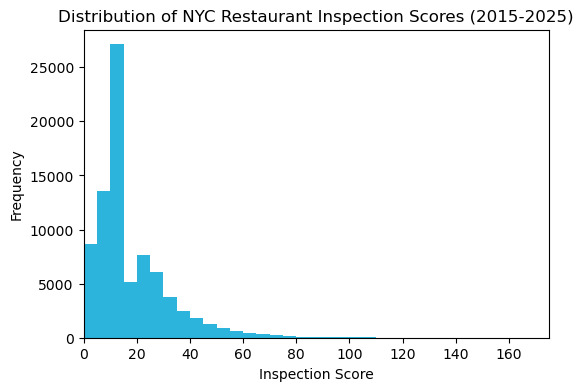

In [46]:
# Grab the inspection scores with the grouping described above
inspection_scores = df.groupby(['inspection_date', 'restaurant_id'])['score'].median()  # all inspections have one unique score

# Generate the histogram
plt.figure(figsize=(6,4))
inspection_scores.plot(kind='hist',bins=35,color='#2cb4dc')
plt.xlim(0,inspection_scores.max())
plt.title('Distribution of NYC Restaurant Inspection Scores (2015-2025)')
plt.xlabel('Inspection Score')
plt.show()

We can see that there is a tall peak right around the decision point (13) between an A grade and a non-A grade.  While we are here, it would be useful to create an inspection id column for our dataframe.  We can do this by using the same groupby as before, sorting the index in ascending order of time, and then setting the values of the series to continuous integers.  Let's do that here.

In [47]:
# Sort the groupby by date in ascending order and make the new index the inspection_id
sorted_inspections = inspection_scores.sort_index(level='inspection_date',ascending=True).reset_index().reset_index()
sorted_inspections = sorted_inspections.rename(columns={'index':'inspection_id'}).drop('score',axis=1)
sorted_inspections.head(5)

,inspection_id,inspection_date,restaurant_id
0,0,2014-04-08,40423450
1,1,2014-05-20,40423450
2,2,2014-10-09,40423450
3,3,2014-10-22,40423450
4,4,2014-11-20,40423450


Now, we can simply merge the inspection ID into our original dataframe.

In [48]:
# Perform the merge, ensuring that the new df has the same number of rows as it did before
before_merge = len(df)
df = pd.merge(df,sorted_inspections,on=['inspection_date','restaurant_id'],how='left')
after_merge = len(df)
if before_merge==after_merge:
    print('Merge successful: df has the same number of rows')

Merge successful: df has the same number of rows


### Encoding Categorical Features

Our categorical features will have to be engineered before they are encoded.  Many of our categorical features have lots of unique levels, so we will have to find a way to reduce the number of levels, and thus the potential dimensionality of our data.  This will be done in the feature engineering phase of the project.

### Handling Imbalanced Data

In order to tell how imbalanced our dataset is, we must first create the binarized response from our score.  It will simply be an indicator for whether or not a grade was an A.  Scores of 0-13 receive an A grade, while scores 14 and above do not receive an A.  Let's create that response and then see how imbalanced it is.  We will hold on to the score feature for now since we may wish to do some feature engineering with it in the future, although we will ultimately have to remove it before fitting our model.

In [49]:
# Create the binarized response
df['grade'] = df['score'].apply(lambda x: 'A' if x<=13 else 'Not A')
# Group by the inspection ID
inspection_grades = df.groupby('inspection_id')['grade'].agg(pd.Series.mode)
# Observe the distribution of the response
inspection_grades.value_counts(normalize=True)

grade
A        0.604582
Not A    0.395418
Name: proportion, dtype: float64

Fortunately for us, the dataset is not terribly imbalanced.  The majority of inspections receive a grade of A, but the number of inspections resulting in a non-A grade are not so numerous as to require advanced methods of artificial class balancing at this point.  Our dataset is clean and ready for the EDA and feature engineering phases.  We will continue those in another notebook with the data we save here.

### Saving the Cleaned Data

In [50]:
# Check the dimensions of the dataset before saving
df.shape

(269901, 18)

In [51]:
# Save the cleaned data to a .csv file
df.to_csv('../data/Cleaned_Inspection_Data.csv',index=False)